# Détection de faux billets

<br>

![logo](https://user.oc-static.com/upload/2020/11/25/16063163322759_Screen%20Shot%202020-11-05%20at%2011.15.15.png)

<br>

Mettre en place une modélisation qui permet d’identifier automatiquement les vrais des faux billets, à partir des dimensions du billet et des éléments qui le composent.

Il y a un fichiers csv qui est mis à disposition :

- billets.csv : un fichier qui contient les informations sur la longueur du billet, sa hauteur gauche (mesurée sur le côté gauche), sa hauteur droite (mesurée sur le côté droit), la marge entre le bord supérieur du billet et l'image de celui-ci, la marge entre le bord inférieur du billet et l'image de celui-ci et sa diagonale. Toutes ces valeurs sont exprimées en millimètres.


## Table des matières

* [Import des librairies et des données](#import)  

* [Observation du Dataframe](#dataframe)

* [Analyse descriptive des données](#analyse_descriptive)
    - [Répartition des billets](#repartition_billet)
    - [Distribution des variables](#distribution)
    - [Pairplot sur la variable vrai/faux billet](#pairplot)
    - [Variance entre les billets vrais/faux par rapport aux autres variables](#boxplot_billet)
    - [Corrélation entre les différentes variables](#heatmap)

* [Traitement des valeurs manquantes](#manquant)

* [Méthode de prédiction](#methode) 
    - [Kmeans](#kmeans)
    - [Régression logistique](#regression_logistique)


## Import des librairies et des données <a name="import"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import levene


billets = pd.read_csv("C:/Users/Greg/Documents/entreprise/data/Openclassroom/Projet 10 Détectez des faux billets avec R ou Python/billets.csv", sep=";")

## Observation du Dataframe <a name="dataframe"></a> 

In [2]:
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


Le dataframe est composé de 1500 lignes.

On va vérifier s'il y a des valeurs manquantes dans le dataframe.

In [3]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il y a 37 valeurs manquantes, on verra plus tard comment les traiter.

In [5]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Aucun problème sur les valeurs numériques.

In [6]:
billets['is_genuine'].unique()

array([ True, False])

La colonne is_genuine contient bien les valeurs True et False.  

## Analyse descriptive des données <a name="analyse_descriptive"></a> 

### Répartition des billets <a name="repartition_billet"></a> 

In [7]:
print("Nombre de vrai billets :", billets.loc[billets['is_genuine'] == True]['is_genuine'].count(), "\nNombre de faux billets :", billets.loc[billets['is_genuine'] == False]['is_genuine'].count())

Nombre de vrai billets : 1000 
Nombre de faux billets : 500


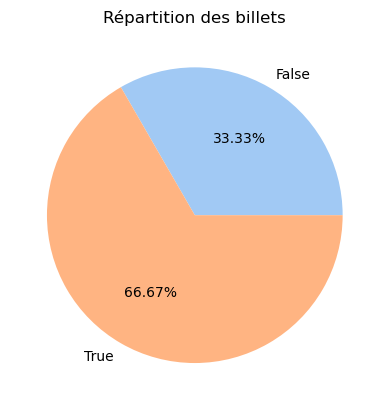

In [2]:
# Regroupement par nombre de billets vrai/faux.
nb_billets = billets.groupby('is_genuine').count()

# Reset de l'index.
nb_billets = nb_billets.reset_index()

# Attribution de la couleur
colors = sns.color_palette('pastel')[0:5]

plt.title('Répartition des billets')
plt.pie(x = nb_billets['diagonal'], labels = nb_billets['is_genuine'], colors = colors, autopct='%.2f%%')
plt.show()

Les faux billets représentent le tiers des billets total.

### Pairplot sur la variable vrai/faux billet <a name="pairplot"></a> 

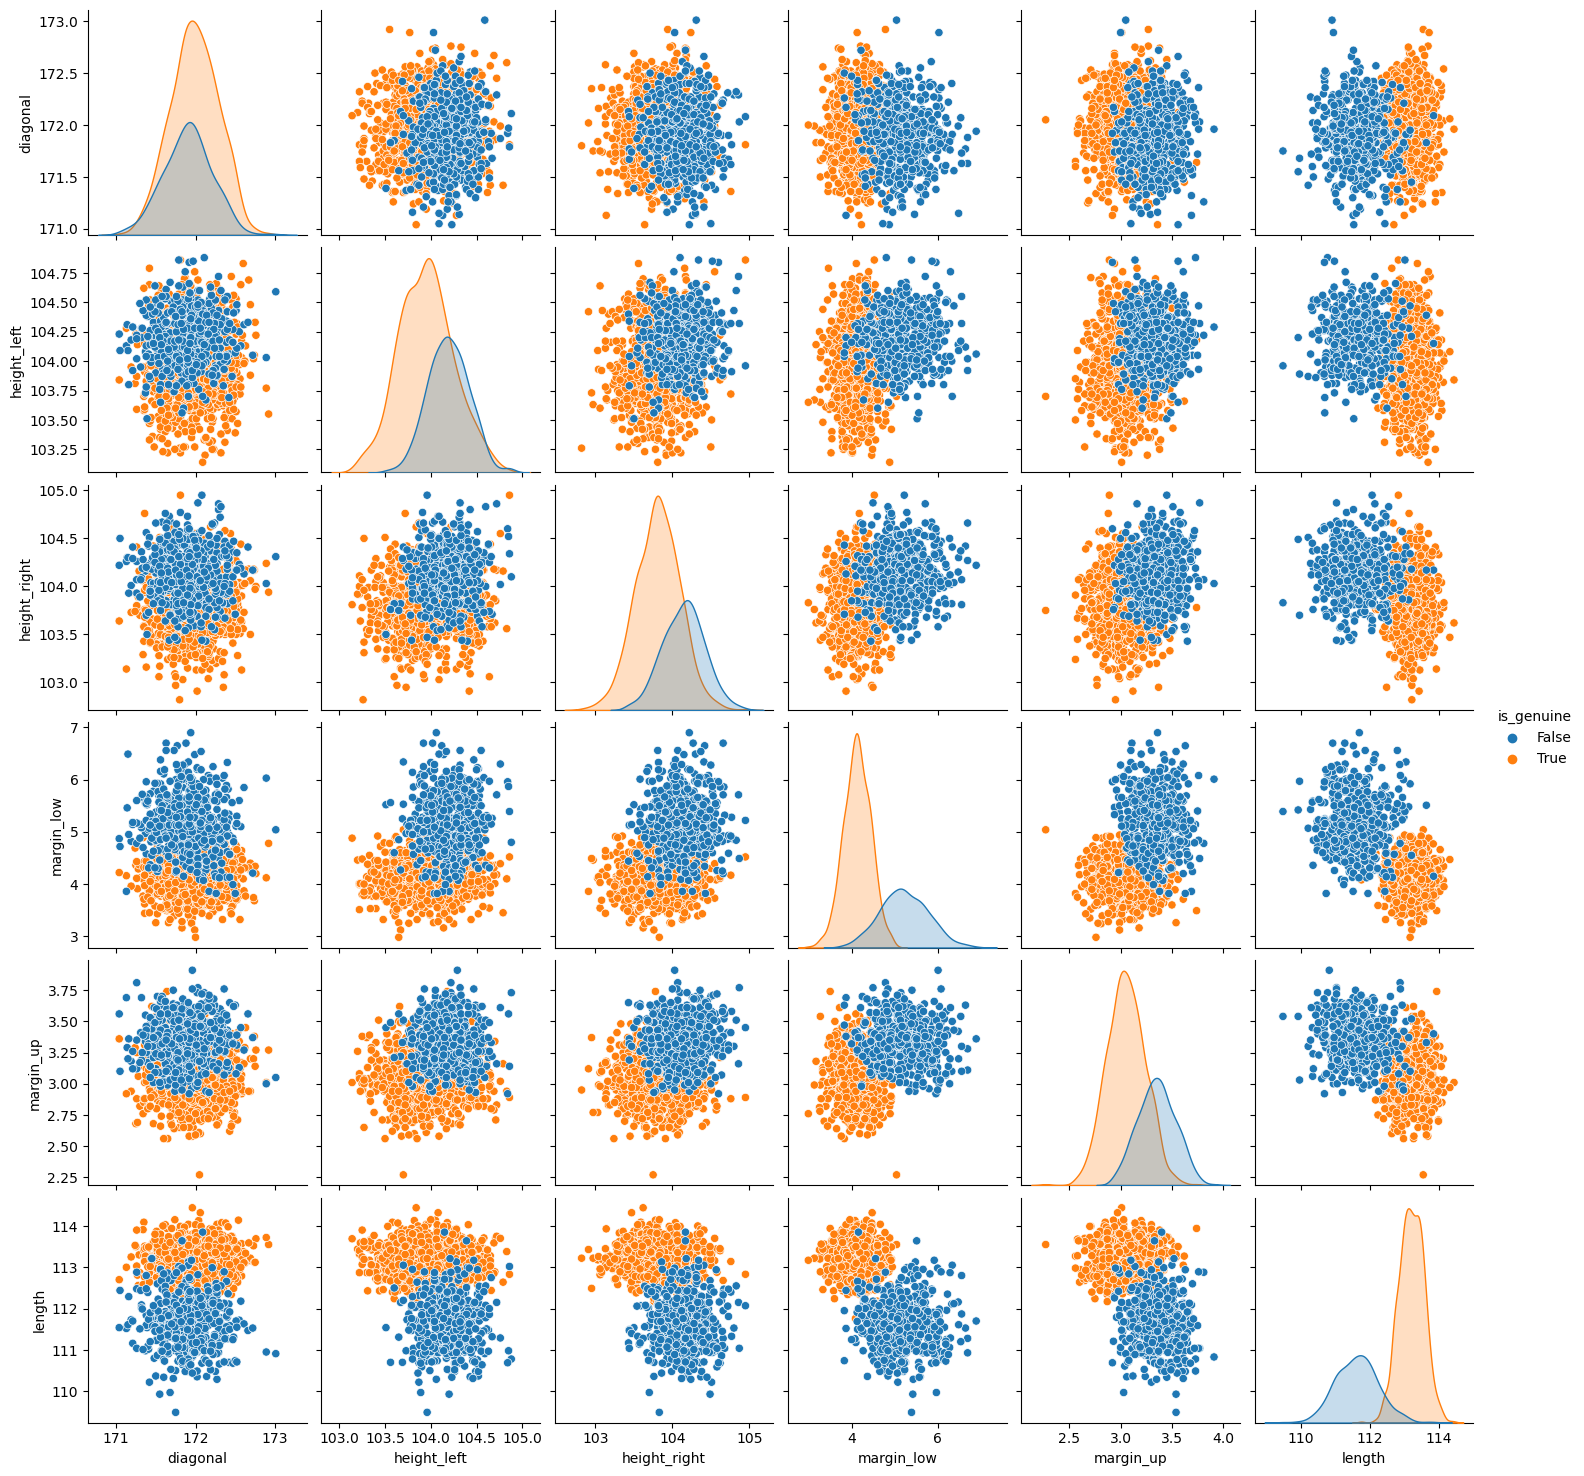

In [9]:
sns.pairplot(billets, hue='is_genuine')

### Distribution des variables <a name="distribution"></a>

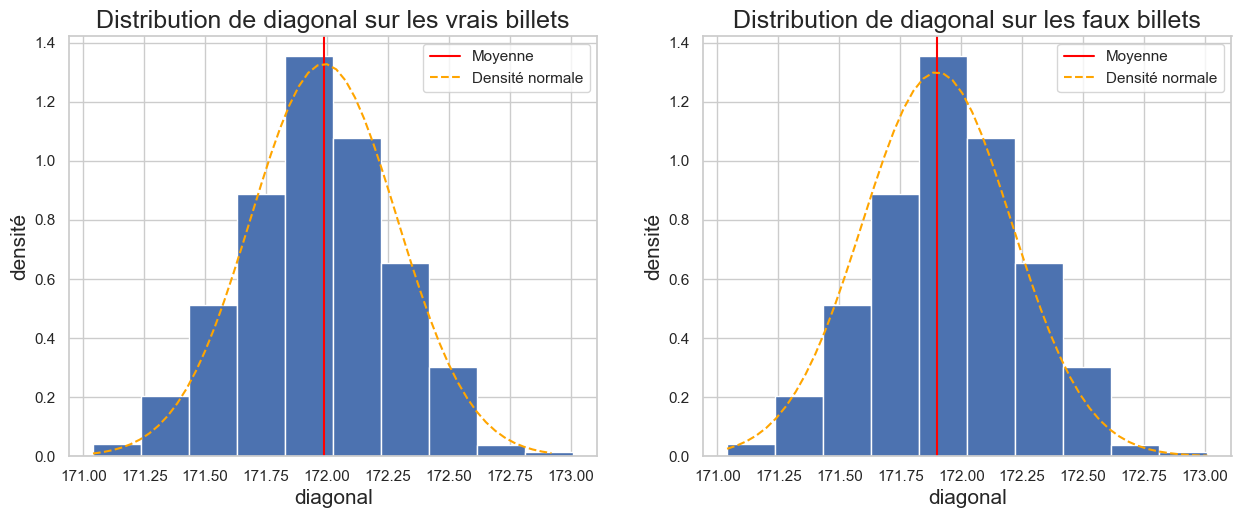

In [3]:
def distribution(var):
    
    plt.figure(figsize=(15, 12))
    sns.set(style="whitegrid")

    ### Vrai billet.
    # Récupération de la moyenne.
    moy_true = billets.loc[billets['is_genuine'] == True, var].mean()

    # Récupération de l'écrat type.
    ecart_true = billets.loc[billets['is_genuine'] == True, var].std()

    # Récupération des valeurs minimum et maximum de la colonne
    domain_true = np.linspace(billets.loc[billets['is_genuine'] == True, var].min(), billets.loc[billets['is_genuine'] == True, var].max())

    # Création de l'histogramme.
    plt.subplot(221)
    plt.hist(billets[var], density=True)

    # Affiche la moyenne dans le graphique.
    plt.axvline(moy_true, color = 'red', linestyle = 'solid', label="Moyenne")

    # Récupére la densité de probabilité .
    pdf_norm_true = norm.pdf(domain_true, moy_true, ecart_true)

    # Affiche la distrubition normale (gaussienne)
    plt.plot(domain_true, pdf_norm_true, color='orange', linestyle = 'dashed', label="Densité normale")

    plt.xlabel(var, size=15)
    plt.ylabel('densité', size=15)
    
    plt.title("Distribution de " + var + " sur les vrais billets", size = 18)
    plt.legend()

    ### Faux billet.
    # Récupération de la moyenne.
    moy_false = billets.loc[billets['is_genuine'] == False, var].mean()

    # Récupération de l'écrat type.
    ecart_false = billets.loc[billets['is_genuine'] == False, var].std()

    # Récupération des valeurs minimum et maximum de la colonne
    domain_false = np.linspace(billets.loc[billets['is_genuine'] == False, var].min(), billets.loc[billets['is_genuine'] == False, var].max())

    # Création de l'histogramme.
    plt.subplot(222)
    plt.hist(billets[var], density=True)

    # Affiche la moyenne dans le graphique.
    plt.axvline(moy_false, color = 'red', linestyle = 'solid', label="Moyenne")

    # Récupére la densité de probabilité .
    pdf_norm_false = norm.pdf(domain_false, moy_false, ecart_false)

    # Affiche la distrubition normale (gaussienne)
    plt.plot(domain_false, pdf_norm_false, color='orange', linestyle = 'dashed', label="Densité normale")

    plt.xlabel(var, size=15)
    plt.ylabel('densité', size=15)
    
    plt.title("Distribution de " + var + " sur les faux billets", size = 18)
    plt.legend()
    
    plt.show()
    
    
distribution('diagonal')

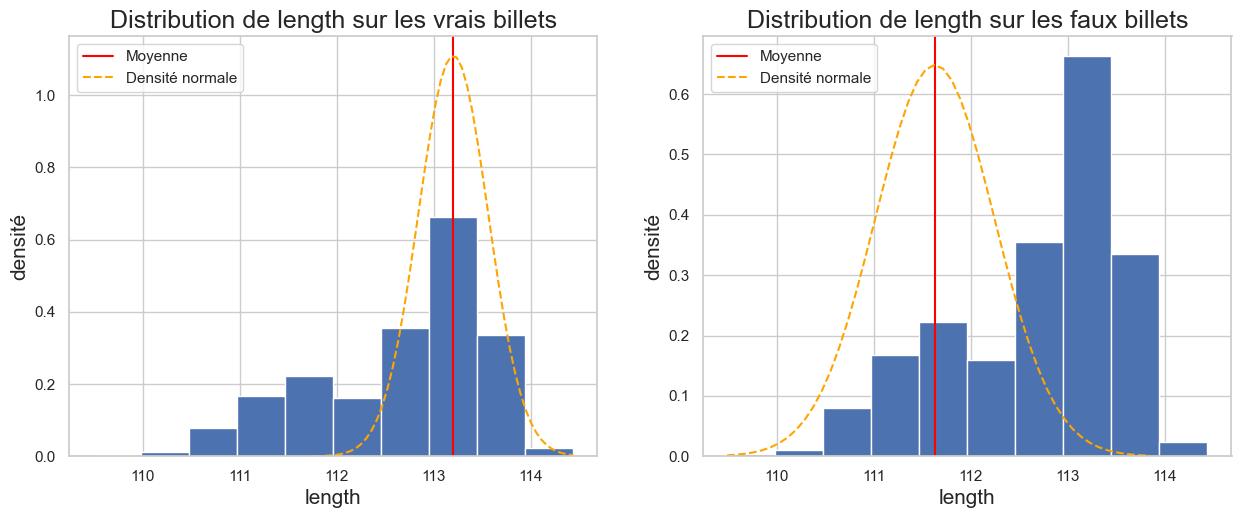

In [4]:
distribution('length')

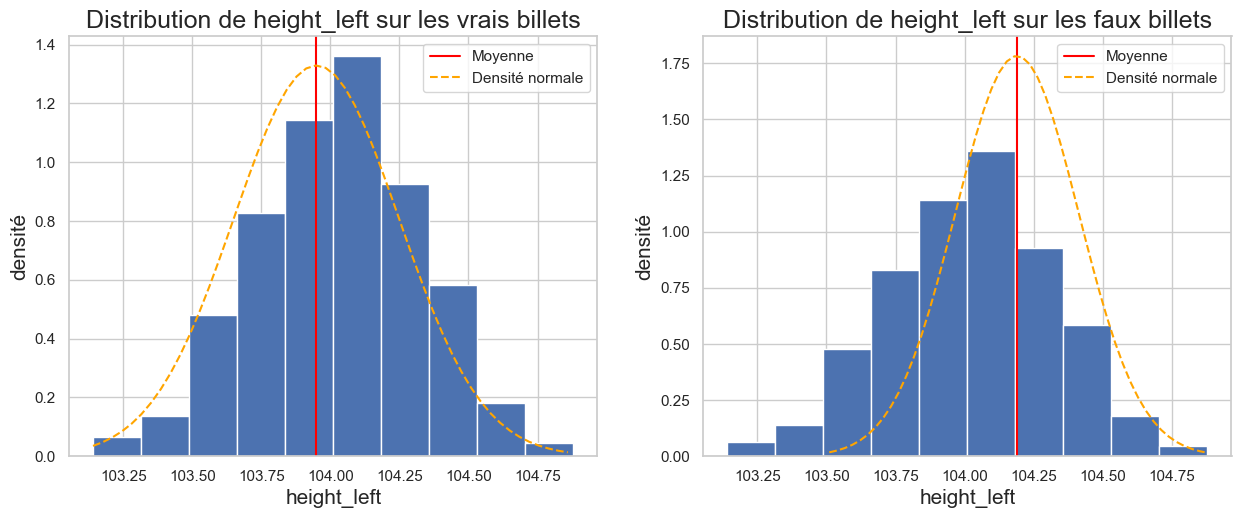

In [12]:
distribution('height_left')

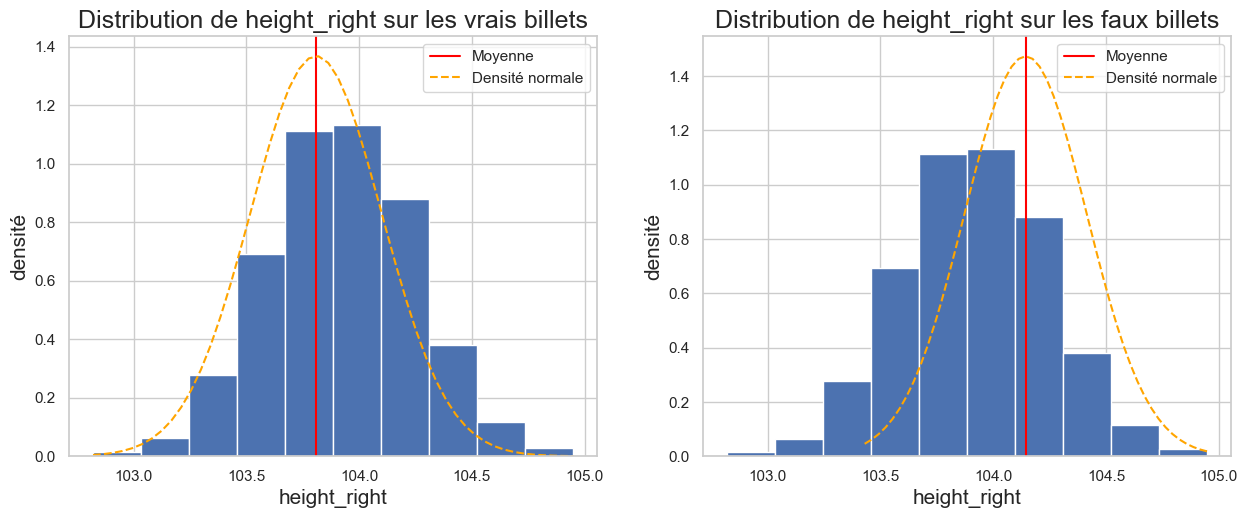

In [13]:
distribution('height_right')

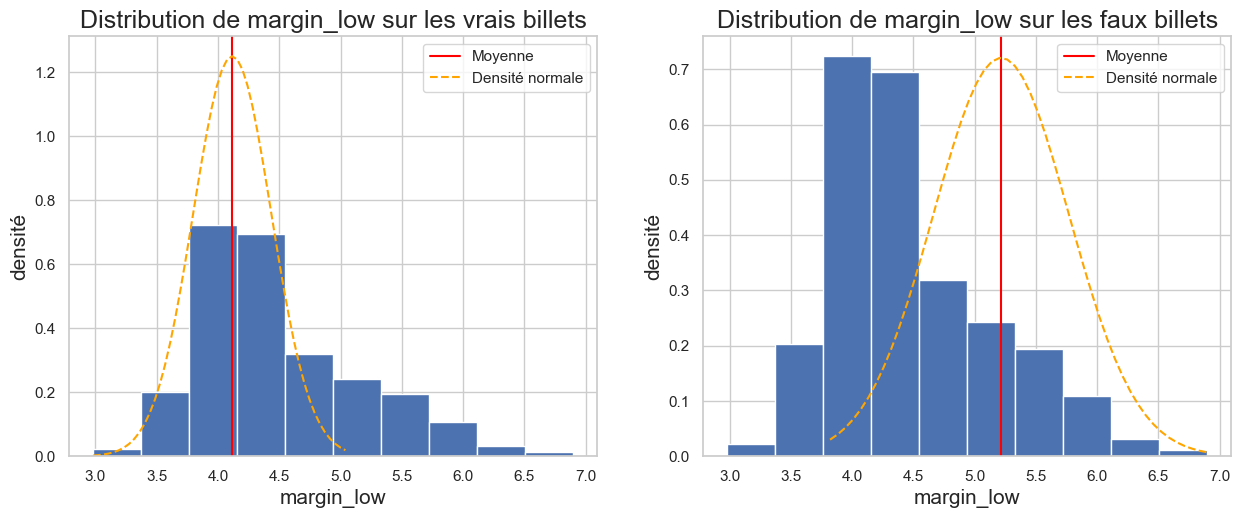

In [14]:
distribution('margin_low')

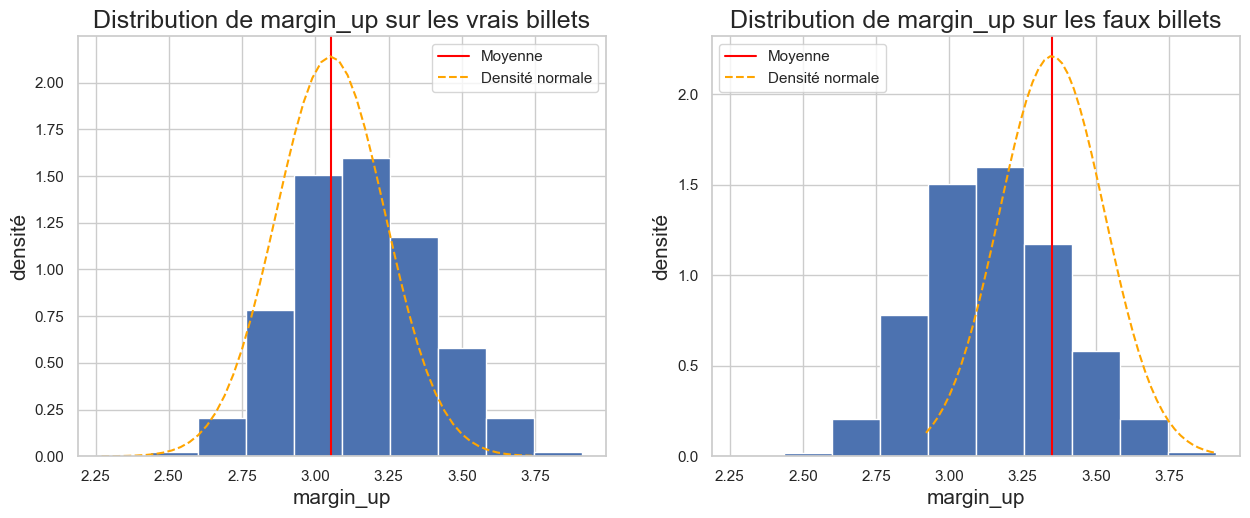

In [15]:
distribution('margin_up')

On remarque que la moyenne des variables diagonal et length pour les vrais billets est plus importante par raport aux faux alors que c'est l'inverse pour les autres variables.  

La distribution des variables pour les vrais billets est normale par contre pour les faux billets on voit qu'elle est complètement décalée pour les variables margin_low et length. De même, pour les variables margin_up et height_right, la densité n'est pas normale.

### Variance entre les billets vrais/faux par rapport aux autres variables <a name="boxplot_billet"></a>

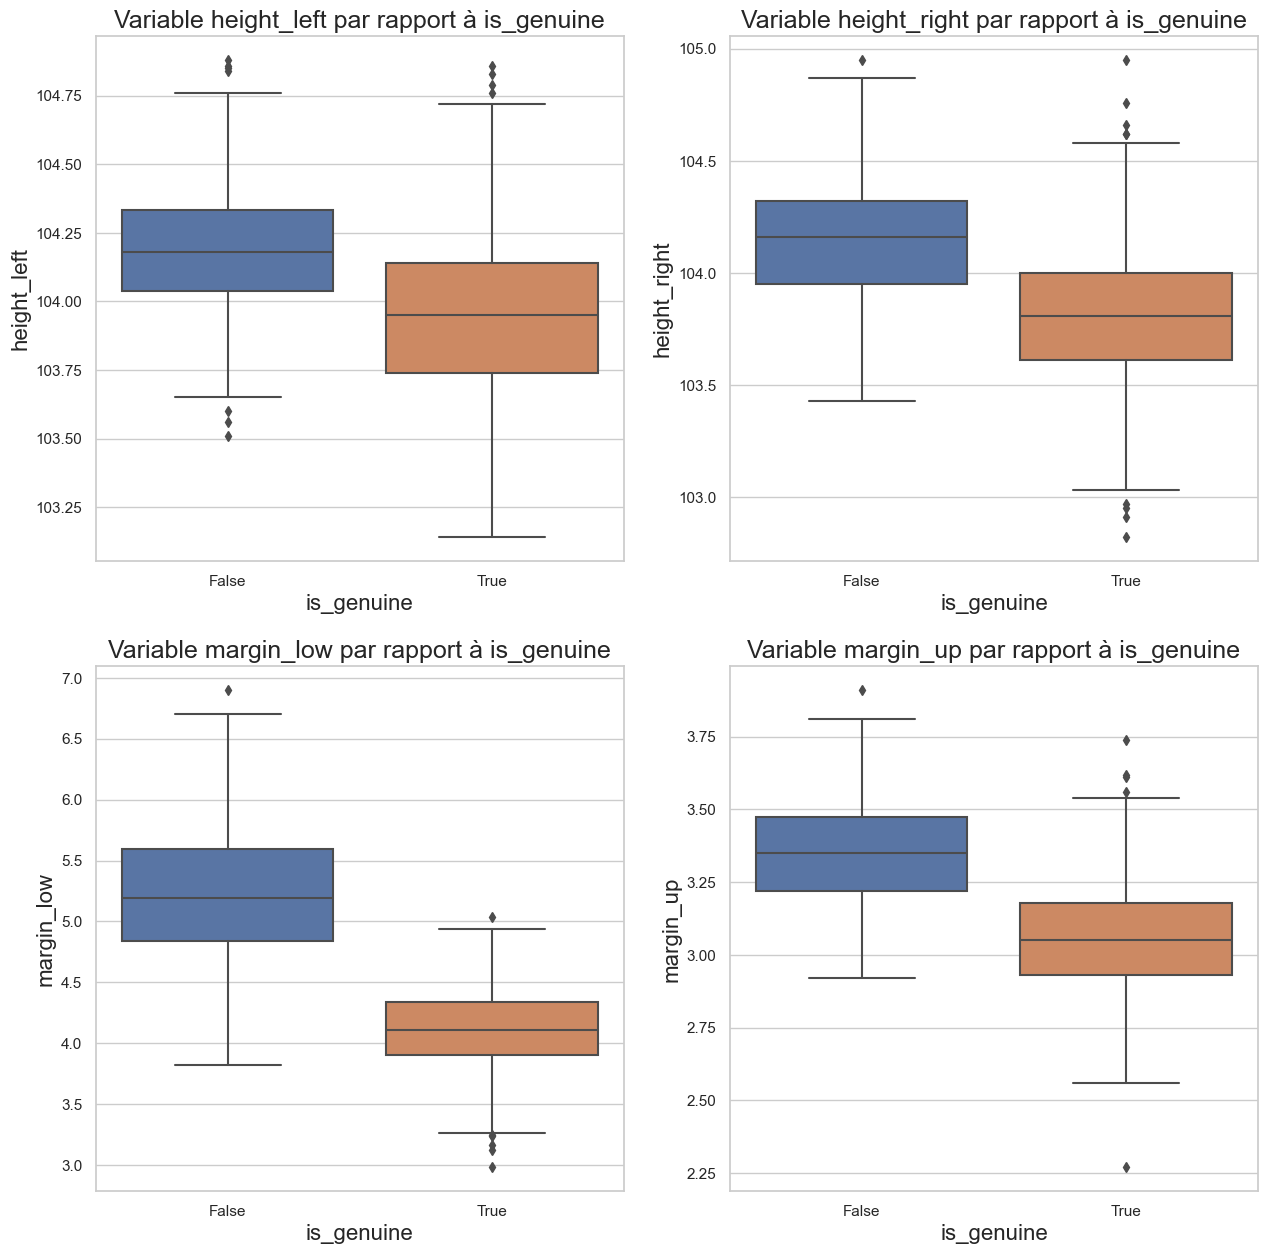

In [3]:
plt.figure(figsize=(15, 15))
sns.set(style="whitegrid")

# Colonne height_left.
plt.subplot(221)
plt.title("Variable height_left par rapport à is_genuine", size = 18)
sns.boxplot(x='is_genuine', y='height_left', data=billets)
plt.xlabel("is_genuine", fontsize = 16)
plt.ylabel("height_left", fontsize = 16)

# Colonne height_right.
plt.subplot(222)
plt.title("Variable height_right par rapport à is_genuine", size = 18)
sns.boxplot(x='is_genuine', y='height_right', data=billets)
plt.xlabel("is_genuine", fontsize=16)
plt.ylabel("height_right", fontsize=16)

# Colonne margin_low.
plt.subplot(223)
plt.title("Variable margin_low par rapport à is_genuine", size = 18)
sns.boxplot(x='is_genuine', y='margin_low', data=billets)
plt.xlabel("is_genuine", fontsize = 16)
plt.ylabel("margin_low", fontsize = 16)

# Colonne margin_up.
plt.subplot(224)
plt.title("Variable margin_up par rapport à is_genuine", size = 18)
sns.boxplot(x='is_genuine', y='margin_up', data=billets)
plt.xlabel("is_genuine", fontsize = 16)
plt.ylabel("margin_up", fontsize = 16)

plt.show()

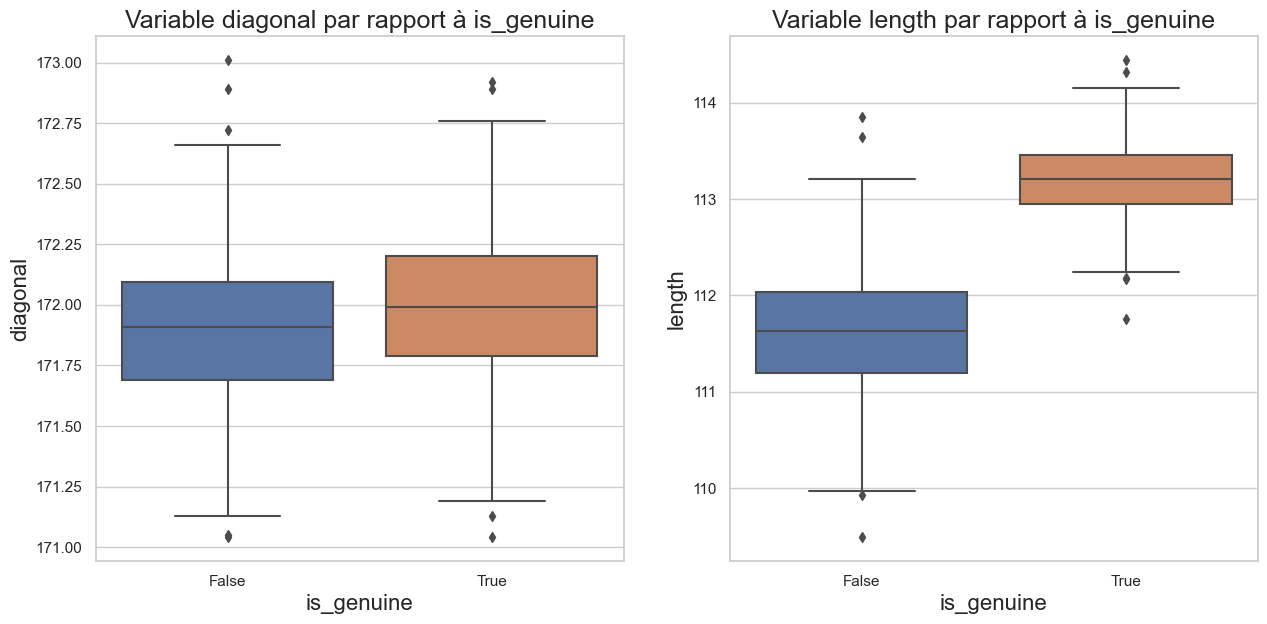

In [4]:
plt.figure(figsize=(15, 15))
sns.set(style="whitegrid")

# Colonne diagonal.
plt.subplot(221)
plt.title("Variable diagonal par rapport à is_genuine", size = 18)
sns.boxplot(x='is_genuine', y='diagonal', data=billets)
plt.xlabel("is_genuine", fontsize = 16)
plt.ylabel("diagonal", fontsize = 16)

# Colonne length.
plt.subplot(222)
plt.title("Variable length par rapport à is_genuine", size = 18)
sns.boxplot(x='is_genuine', y='length', data=billets)
plt.xlabel("is_genuine", fontsize = 16)
plt.ylabel("length", fontsize = 16)

plt.show()

Il y a une différence de variances entre les vrais et les faux billets pour chaque variable même si la variable "diagonal" est moins importante.

### Corrélation entre les différentes variables <a name="heatmap"></a>

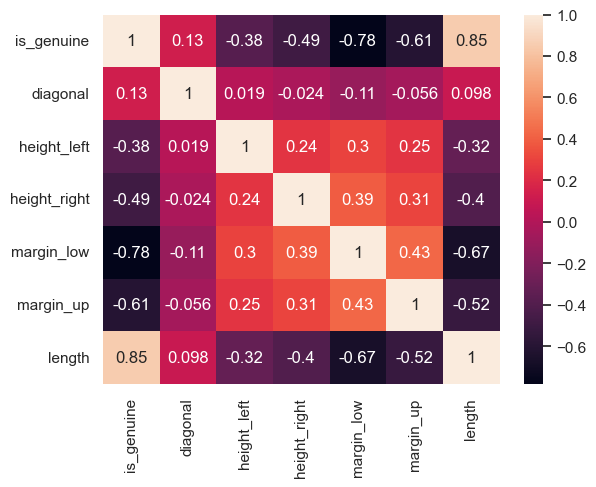

In [7]:
sns.heatmap(billets.corr(), annot=True)
plt.show()

On va passer à l'ajout des valeurs manquantes pour la colonne margin_low.

## Traitement des valeurs manquantes <a name="manquant"></a>

Pour compléter les valeurs manquantes, on va utiliser une régression linéaire.  
On sépare les individus qui ont une valeur manquante dans la colonne margin_low.

In [2]:
# Dataset avec les valeurs manquantes.
data_val_manquant = billets.loc[billets["margin_low"].isna()]

# Dataset sans les valeurs manquantes.
data_sans_val_manquant = billets.dropna()

On va ensuite retirer les variables non significatives.

In [3]:
# Fonction pour trouver les varibles descriptives les plus pertinentes.
def backward_selected(data, response):

    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.ols(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model !')
        print('')
    print(model.summary())
    
    return model

# Utilisation de la fonction backward_selected.
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
reg_backward = backward_selected(data_sans_val_manquant[columns], 'margin_low')

_______________________________
margin_low ~ length + diagonal + is_genuine + margin_up + height_right + height_left + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ diagonal + is_genuine + margin_up + height_right + height_left + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ is_genuine + margin_up + height_right + height_left + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ is_genuine + margin_up + height_left + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

Le 𝑅² vaut environ 0.62, et le 𝑅² ajusté est d'environ 0.62.

Les paramètres sont significatifs, pour les valeurs is_genuine et margin_up. On va conserver ces 2 valeurs.

In [4]:
data_regr_lineaire= data_sans_val_manquant.drop(['diagonal','length','height_right','height_left'],axis=1)

data_regr_lineaire.head()

,is_genuine,margin_low,margin_up
0,True,4.52,2.89
1,True,3.77,2.99
2,True,4.40,2.94
3,True,3.62,3.01
4,True,4.04,3.48


In [5]:
reg_multi = smf.ols('margin_low~+is_genuine+margin_up ', data=data_regr_lineaire).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Wed, 01 Nov 2023   Prob (F-statistic):          1.24e-304
Time:                        17:28:57   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

### Vérification par test

Avant de valider l'utilisation de la régression linéaire, on va utiliser plusieurs tests afin de s'assurer qu'il est possible d'appliquer cette régression. Voici les tests à effectuer :

- Normalité : Les erreurs résiduelles doivent être distribuées normalement. Cela signifie que les résidus doivent suivre une distribution normale avec une moyenne de zéro.
- Homoscédasticité : L'homoscédasticité signifie que la variance des erreurs résiduelles est constante à tous les niveaux de la variable prédite.
- Colinéarité : Cette hypothèse concerne la relation entre les variables prédictives (ou indépendantes) dans notre modèle de régression. Elle stipule qu'il ne devrait pas y avoir de forte corrélation linéaire entre les variables indépendantes.  

**Test de la normalité des résidus**

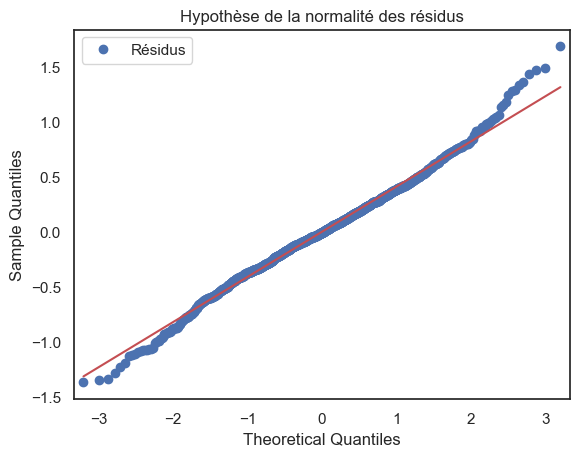

In [12]:
# Calcul des résidus
residuals = reg_multi.resid

sns.set(style="white")
sm.qqplot(residuals, line='s', label="Résidus")
plt.title("Hypothèse de la normalité des résidus")
plt.legend()
plt.show()

Si l'on veut tester la normalité des résidus, on peut faire également un test de Shapiro-Wilk.

In [13]:
statistic, p_value = shapiro(residuals)

if p_value > 0.05:
    print("Les résidus semblent suivre une distribution normale (hypothèse non rejetée).")
    print("P-value :",p_value)
else:
    print("Les résidus ne suivent pas une distribution normale (hypothèse rejetée).")
    print("P-value :",p_value)

Les résidus ne suivent pas une distribution normale (hypothèse rejetée).
P-value : 6.20942773821298e-06


C:\Users\Greg\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


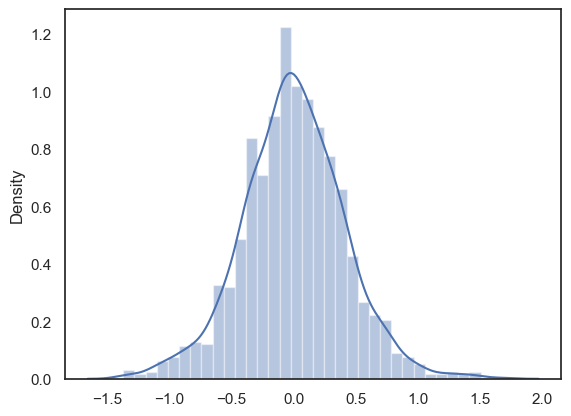

In [14]:
sns.distplot(residuals)
plt.show()

L'observation des résidus montre qu'il n'est pas très différent d'une distribution symétrique et le fait que l'échantillon soit de taille suffisante permet de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

**Test de l'homoscédasticité des résidus**

In [15]:
# On récupère les résidus.
residuals = reg_multi.resid

# On récupère la variable prédite.
predicted = reg_multi.fittedvalues

# On divise les résidus en groupes en fonction de la variable prédite.
groups = pd.qcut(predicted, q=5, labels=False)

# On effectue le test de Levene sur les résidus groupés.
levene_test = levene(*[residuals[groups == i] for i in np.unique(groups)], center='mean')

# On obtiens la statistique de test et la valeur p.
test_statistic = levene_test.statistic
p_value = levene_test.pvalue

# On affiche les résultats.
print("Test de Levene:")
print("Statistique de test :", test_statistic)
print("P-value  :", p_value)

Test de Levene:
Statistique de test : 41.335456318169726
P-value  : 7.359885063990044e-33


Le test de Levene indique une statistique de test de 41.33 et une P-value faible (7.35e-33). Cela indique un rejet de l'hypothèse d'homoscédasticité dans notre modèle de régression linéaire.

**Test de Colinéarité**

In [16]:
X = data_regr_lineaire.drop(['margin_low'], axis=1)

# On calcule les VIF pour chaque variable explicative.
vif = pd.DataFrame()
vif["Variable"] = X.columns

variables = reg_multi.model.exog
vif["VIF"] =[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

# On affiche les résultats.
print("Variance Inflation Factor (VIF):")
print(vif)

Variance Inflation Factor (VIF):
     Variable       VIF
0  is_genuine  1.593885
1   margin_up  1.593885


Les valeurs VIF pour les variables explicatives is_genuine et margin_up sont toutes deux de 1.59, il n'y a donc pas de problème de colinéarité.

**Insertion des valeurs manquantes**

In [6]:
# On définit la valeur X.
X = data_val_manquant.drop(["margin_low","height_right","length","diagonal","height_left"], axis=1)

In [7]:
# On réalise la prédiction à l'aide du model créé avec StatModel.
prediction = round(reg_multi.predict(X),2)

In [8]:
# On ajoute les nouvelles données aux données de base.
billets['margin_low'] = billets['margin_low'].fillna(prediction)

billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [9]:
billets.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Les nouvelles données ont bien été rajoutées.

## Méthode de prédiction <a name="methode"></a>

Deux méthodes de prédiction vont être mis en concurrence :
- un kmeans, duquel seront utilisés les centroïdes pour réaliser la prédiction.
- une régression logistique classique.

### Kmeans <a name="kmeans"></a>

In [21]:
# Préparation des données pour le clustering.
df_kmeans = billets[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
# Mettre les valeurs dans un array Numpy.
X = df_kmeans.values

In [22]:
from sklearn import preprocessing

# On instancie le scaler.
std_scale = preprocessing.StandardScaler().fit(X)

# On transforme les données.
X_scaled = std_scale.transform(X)

In [23]:
from sklearn.cluster import KMeans

# Clustering par Kmeans avec librairie sklearn sur les données centrées réduites.
km = KMeans(n_clusters=2, random_state=22)
km.fit(X_scaled)

KMeans(n_clusters=2, random_state=22)

In [24]:
# Récupération des clusters.
clusters_km = km.labels_ 
clusters_km

array([0, 1, 1, ..., 0, 0, 0])

**ACP - Eboulis des valeurs propres** <a name="ACP_eboulis"></a>

In [25]:
# On instancie notre ACP. 
pca = PCA().fit(X_scaled)

In [26]:
# Pourcentage de variance expliqué par les composantes.
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([43.2 , 16.96, 13.02, 11.83,  9.67,  5.33])

On remarque que les 2 premières composantes captent 62,16 % (43,2 + 16,96) de la variance. 

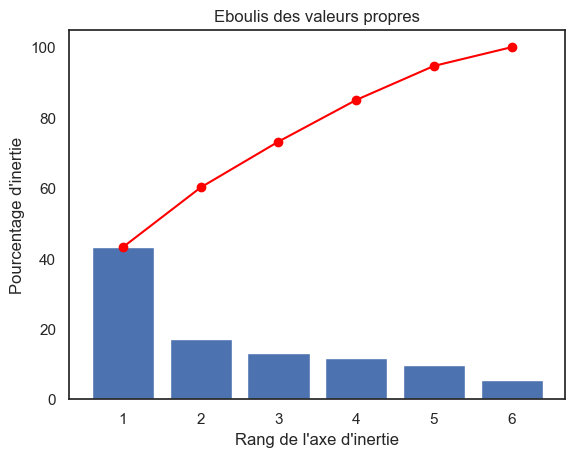

In [27]:
# Représentation graphique.
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    
plt.xlabel("Rang de l'axe d'inertie")
plt.ylabel("Pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show()

On remarque que les 2 premières composantes représente 62,16 %, une analyse sur le premier plan factoriel sera satisfaisante.  

**ACP - Cercle des corrélations**

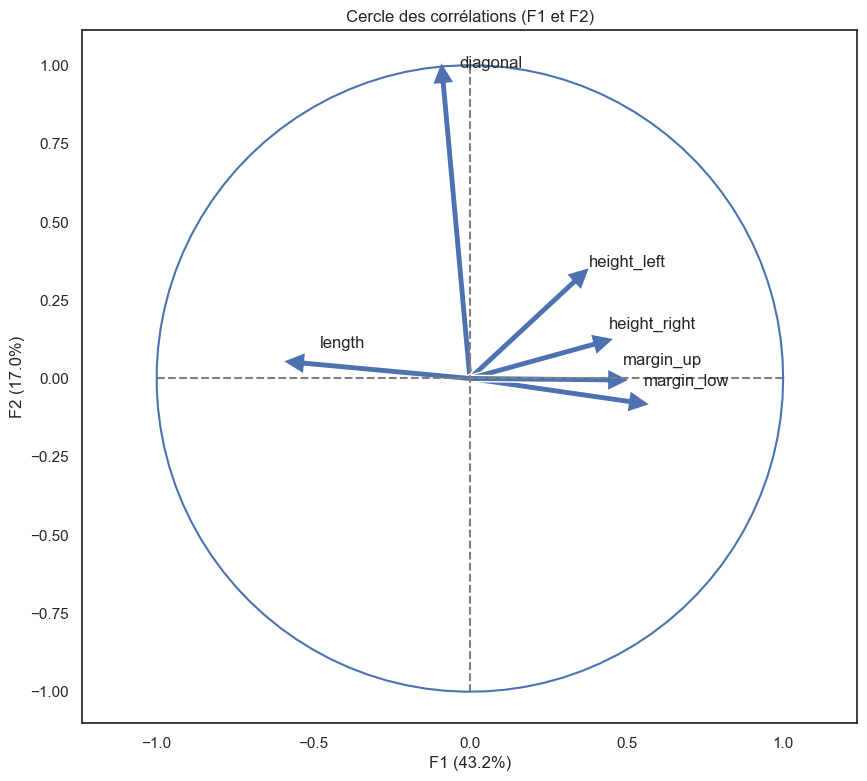

In [28]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 

    # Extrait x et y. 
    x,y=x_y

    # Taille de l'image (en inches).
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches.
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels.
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales.
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué.
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title('Cercle des corrélations (F{} et F{})'.format(x+1, y+1))

    # Le cercle. 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display.
    plt.axis('equal')
    plt.show(block=False)
    

correlation_graph(pca, (0,1), df_kmeans.columns)

En F1, les variables diagonal et length sont décorrélées par rapport aux autres variables.
Pour la composante F2, ce sont les variables margin_low et margin_up qui sont décorrélées par rapport au reste des variables.  

**ACP - Projection sur plan factoriel**

In [29]:
X_proj = pca.transform(X_scaled)

# Affichage sur plusieurs plans factoriels avec inertie des axes.
def plot_plans_factoriels(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, centroid=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialisation de la figure.       
            fig = plt.figure(figsize=(12,8))
        
            # Affichage des points.
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Affichage des labels des points.
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Affichage des positions des centres de classes.
            if centroid is not None:
                centroids = km.cluster_centers_
                centroids_projected = pca.transform(centroids)
                for j,(x1,y1) in enumerate(centroids_projected[:,[d1,d2]]):
                    plt.scatter(x1,y1, c = 'red', marker='x', s=100, label='Centroides')
            
            # Détermination des limites du graphique.
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Affichage des lignes horizontales et verticales.
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title('Projection des {} individus sur F{} et F{}'.format(X_projected.shape[0], d1+1, d2+1), fontsize=22)
            plt.show(block=False)

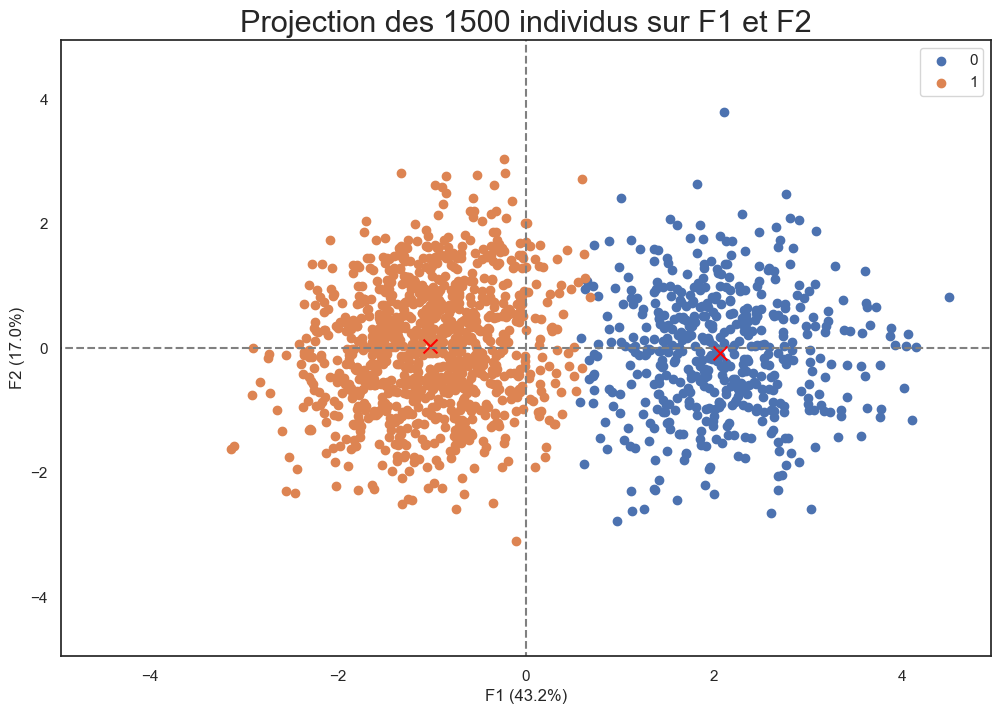

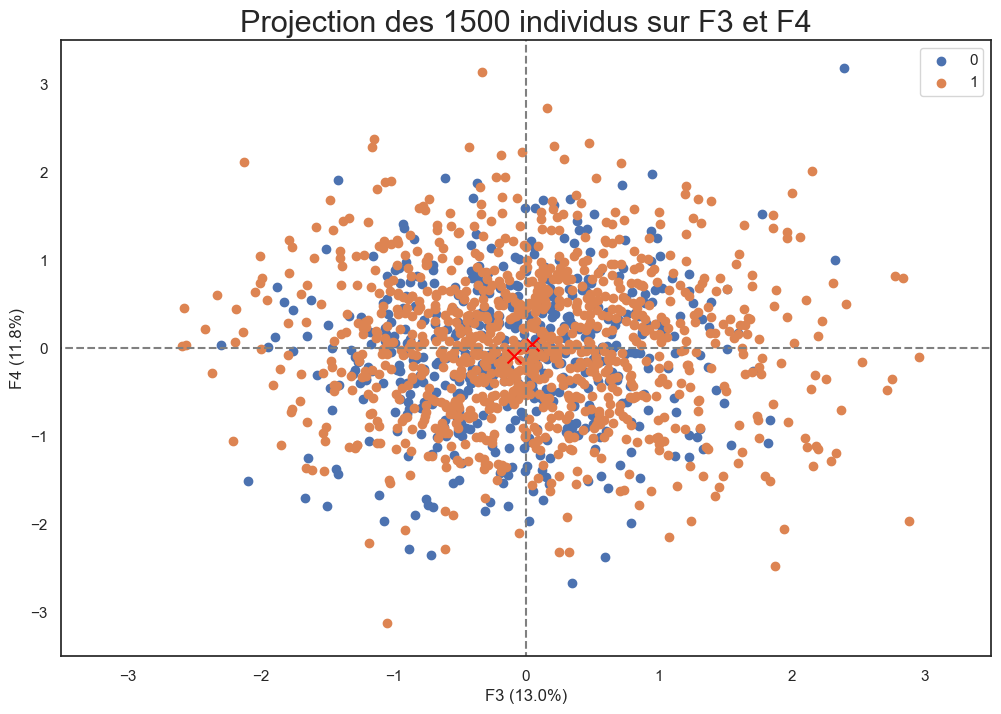

In [30]:
plot_plans_factoriels(X_proj, 4, pca, [(0,1),(2,3)], illustrative_var = clusters_km, centroid=1)

La projection nous permet de mieux représenter les groupes pour permettre une sélection.  
Les croix rouges montrent les centroïdes des clusters.  

**Métrique de l'inertie**

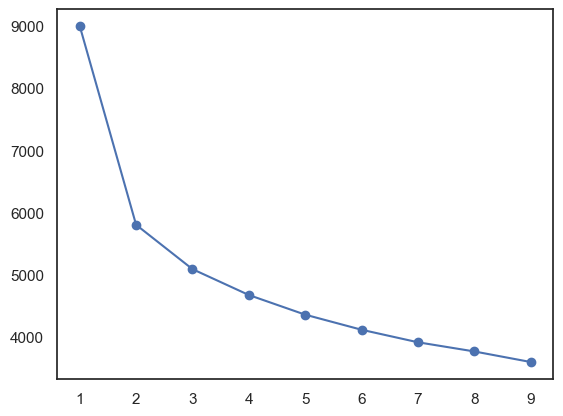

In [31]:
from sklearn import cluster

# On crée une liste dans laquelle on stocke les inerties.
inerties=[]

# On fait une boucle de 1 à 9 pour tester toutes ces possibiliéts.
for k in range(1, 10):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = cluster.KMeans(n_clusters=k)
    km.fit(X_scaled)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

# Visualisation des valeurs d'inertie pour chaque nombre de cluster.
plt.plot(range(1, 10), inerties, marker='o')
plt.show()

Le choix de 2 clusters est la meilleur solution comme on veut une séparation binaire (Vrai / Faux). 

**Attribution des cluters Kmeans**

In [32]:
df_kmeans['cluster'] = clusters_km

df_kmeans

,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,171.81,104.86,104.95,4.52,2.89,112.83,0
1,171.46,103.36,103.66,3.77,2.99,113.09,1
2,172.69,104.48,103.50,4.40,2.94,113.16,1
3,171.36,103.91,103.94,3.62,3.01,113.51,1
4,171.73,104.28,103.46,4.04,3.48,112.54,1
...,...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28,0
1496,172.19,104.63,104.44,5.27,3.37,110.97,0
1497,171.80,104.01,104.12,5.51,3.36,111.95,0
1498,172.06,104.28,104.06,5.17,3.46,112.25,0


**Matrice de confusion**  

Pour une évaluation optimale des modèles, on va réaliser une annalyse des nombres de faux positifs et faux négatifs via une matrice de confusion.

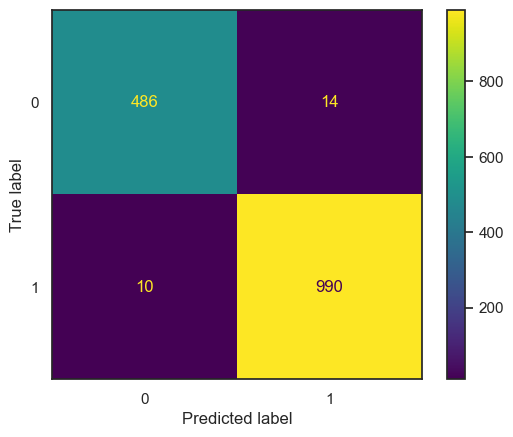

In [33]:
y = billets["is_genuine"]

# On réalise notre matrice de confusion.
cf = confusion_matrix(y, df_kmeans.cluster)
cm = ConfusionMatrixDisplay(cf)
cm.plot()
plt.show()

Vrais négatifs : 486  
Vrais positifs : 990  
Faux négatifs : 14  
Faux positifs : 10  

### Régression logistique <a name="regression_logistique"></a>  

Pour faire la régression logistique, il faut préparer les données. La variable is_genuine va être transformée en variable numérique (Vrai = 1 et Faux = 0).

In [10]:
billets["is_genuine"].replace([True, False], [1,0], inplace=True)

In [11]:
# Fonction pour trouver les varibles descriptives les plus pertinentes.
def backward_selected_logistic(data, response):
    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response, ' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.logit(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value:', round(toRemove.values[0], 3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model!')
        print('')
    print(model.summary())

    return model

In [12]:
# Utilisation de la fonction.
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
reg_backward = backward_selected_logistic(billets[columns], 'is_genuine')

_______________________________
is_genuine ~ length + diagonal + margin_low + margin_up + height_right + height_left + 1
Optimization terminated successfully.
         Current function value: 0.026325
         Iterations 13
remove diagonal (p-value: 0.813 )

_______________________________
is_genuine ~ length + margin_low + margin_up + height_right + height_left + 1
Optimization terminated successfully.
         Current function value: 0.026343
         Iterations 13
remove height_left (p-value: 0.254 )

_______________________________
is_genuine ~ length + margin_low + margin_up + height_right + 1
Optimization terminated successfully.
         Current function value: 0.026783
         Iterations 13
is the final model!

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1495
Method:                          

Les variables descriptives significatives sont les suivantes :  
- length
- margin_low
- margin_up
- height_right

In [13]:
# On affecte X et y avec les données nécessaires en retirant les variables descriptives non significatives.
X = billets.drop(["is_genuine","diagonal","height_left"], axis=1)
Y = billets["is_genuine"]

In [14]:
# On définit notre model.
model_logistic = LogisticRegression()

# On entraine notre model.
model_logistic = model_logistic.fit(X, Y)

# On enregistre les prédictions.
y_pred = model_logistic.predict(X)

**Matrice de confusion**

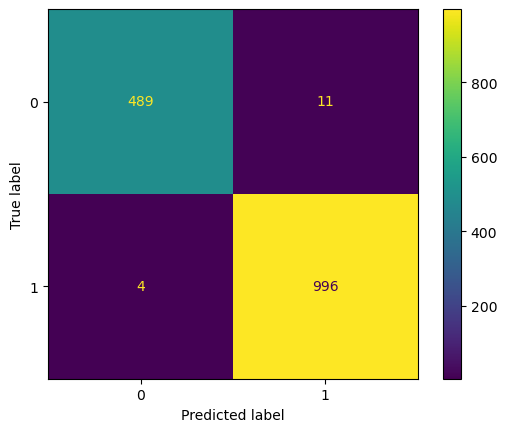

In [15]:
cm = confusion_matrix(Y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Vrais négatifs : 489  
Vrais positifs : 996  
Faux négatifs : 11  
Faux positifs : 4  

**Choix du modèle**  

On remarque que la méthode de prédiction avec régression logistique est plus concluante qu'avec un Kmeans.  

## TEST SOUTENANCE

In [28]:
from sklearn import preprocessing

test = pd.read_csv("C:/Users/Greg/Documents/entreprise/data/Openclassroom/Projet 10 Détectez des faux billets avec R ou Python/billets_production.csv", sep=",")

In [29]:
test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [30]:
data_prediction = test.copy()
data_prediction.drop(["id","diagonal","height_left"], axis=1, inplace=True)

In [31]:
# Standardisation des données.
std_scale = preprocessing.StandardScaler().fit(data_prediction)
X_scaled = std_scale.transform(data_prediction)
test["prediction"] = model_logistic.predict(X_scaled)

C:\Users\Greg\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [32]:
# Affichage des prédictions (Vrai/Faux).
resultat= []
for i in test['prediction'] :
    if i == 1 :
        resultat.append('Vrai')
        
    else :
        resultat.append('Faux')

test['prediction'] = resultat


print(test['prediction'].value_counts())

test

Faux    3
Vrai    2
Name: prediction, dtype: int64


,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,Faux
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,Faux
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,Faux
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,Vrai
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,Vrai


In [33]:
test.to_csv("C:/Users/Greg/Documents/entreprise/data/Openclassroom/Projet 10 Détectez des faux billets avec R ou Python/test.csv", index = False)